In [4]:
# Import basic data science packages
import numpy as np

# Import tensorflow packages
import tensorflow as tf
from tensorflow.test import gpu_device_name

# Import various keras tools
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
device_name = gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/BrainStation\ Capstone\ Project/capstone

/content/drive/MyDrive/BrainStation Capstone Project/capstone


In [8]:
%pwd

'/content/drive/MyDrive/BrainStation Capstone Project/capstone'

In [9]:
#import pcamlib to Google Colab
import imp 
pcamlib = imp.new_module('pcamlib')
exec(open("./pcamlib.py").read(), pcamlib.__dict__)

In [ ]:
# import pcamlib as pc

To get started with this dataset, I adapted the code from this [article](https://geertlitjens.nl/post/getting-started-with-camelyon/) written by Geert Litjens, one of the authors of the dataset.

I used his code for the `train_pipeline`, `valid_pipeline`, and `test_pipeline`, which load the train, validation, and test sets and prepare them for modelling. I also make use of his function `convert_sample`. This function extracts each image and its corresponding label from the dataset, converts each image to a TensorFlow `tf.float32` datatype, then performs one-hot encoding on the labels and converts them to `tf.float32` as well.

In [37]:
directory = '/content/drive/My Drive/BrainStation Capstone Project/tensorflow_datasets'
pcam, pcam_info = tfds.load("patch_camelyon", data_dir=directory, with_info=True, download=False)

ParseError: ignored

In [10]:
pcam, pcam_info = pcamlib.load_pcam()

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete7O578S/patch_camelyon-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete7O578S/patch_camelyon-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete7O578S/patch_camelyon-validation.tfrecord


Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
      

In [11]:
train_pipeline, valid_pipeline, test_pipeline = pcamlib.build_pipelines(pcam)

I also used Geert Litjens CNN layer architecture as a starting point. It resembles a VGG16 architecture because it has three sets of two Convolutional layers followed by a single Max Pooling layer, followed by a Flattening layer and two Dense layers before the final Dense layer which outputs the class predictions. I kept the layer parameters the same as his example.

I changed the optimizer to `Adam` from `SGD` simply because he provided multiple hyperparameters to go along with it, and I wanted to experiment with that on my own. I also added additional Dropout layers after each convolutional layer, because the first iteration of the model started overfitting quickly after the first epoch and the validation accuracy didn't improve beyond 80%.

In [12]:
# Instantiate model object
cnn = Sequential()

# Images are 96x96 px, in RGB so there are 3 channels
image_shape = (96, 96, 3)

# Adding convultional layers to the model 
# It was important to add dropout layers after each convolutional layer to reduce overfitting
cnn.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='valid', input_shape=image_shape))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.25))

# Add a max pool layer to reduce the dimensions of the feature maps
cnn.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))

# Repeating this architecture two more times
cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.25))
cnn.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))
     
cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.25))
cnn.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))

# Flatten the data to prepare for dense layers
cnn.add(Flatten())
        
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.25))

cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.25))

# Final Dense layer to make class predictions
cnn.add(Dense(2, activation='softmax'))
        
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 16)        448       
_________________________________________________________________
dropout (Dropout)            (None, 94, 94, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 16)        2320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 92, 92, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        4640      
_________________________________________________________________
dropout_2 (Dropout)          (None, 44, 44, 32)        0

In [13]:
# For comparison, this commented line is the original optimizer used in the article:
# sgd_opt = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
cnn.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Add early stop callback to prevent the model from overfitting, or running too long
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=5, verbose=1)

In [14]:
%%time
history = cnn.fit(train_pipeline,
                   validation_data=valid_pipeline,
                   verbose=1, epochs=15, steps_per_epoch=4096, validation_steps=256,
                   callbacks=[early_stop])

Epoch 1/15
4096/4096 [==============================] - 263s 59ms/step - loss: 0.4260 - accuracy: 0.8091 - val_loss: 0.3817 - val_accuracy: 0.8253
Epoch 2/15
4096/4096 [==============================] - 239s 58ms/step - loss: 0.3292 - accuracy: 0.8601 - val_loss: 0.3580 - val_accuracy: 0.8365
Epoch 3/15
4096/4096 [==============================] - 240s 59ms/step - loss: 0.2973 - accuracy: 0.8772 - val_loss: 0.3294 - val_accuracy: 0.8567
Epoch 4/15
4096/4096 [==============================] - 240s 59ms/step - loss: 0.2788 - accuracy: 0.8865 - val_loss: 0.3501 - val_accuracy: 0.8449
Epoch 5/15
4096/4096 [==============================] - 239s 58ms/step - loss: 0.2645 - accuracy: 0.8934 - val_loss: 0.3240 - val_accuracy: 0.8543
Epoch 6/15
4096/4096 [==============================] - 240s 59ms/step - loss: 0.2551 - accuracy: 0.8975 - val_loss: 0.3193 - val_accuracy: 0.8595
Epoch 7/15
4096/4096 [==============================] - 238s 58ms/step - loss: 0.2477 - accuracy: 0.9019 - val_loss: 0

In [ ]:
path = '/content/drive/MyDrive/BrainStation\ Capstone\ Project/capstone'

In [15]:
%pwd

'/content/drive/My Drive/BrainStation Capstone Project/capstone'

In [16]:
# Save the fitted model to a file
cnn.save('data/models/cnn1.1')

INFO:tensorflow:Assets written to: data/models/cnn1.1/assets


INFO:tensorflow:Assets written to: data/models/cnn1.1/assets


In [17]:
# Save the history of the model to a csv
pcamlib.save_history(history, 'data/models/history/cnn1.1_history.csv')

In [21]:
# Uncomment the line below to load the model from file if necessary
# cnn = tf.keras.models.load_model("cnn1.1")
hist_df = pcamlib.load_history('data/models/history/cnn1.1_history.csv')

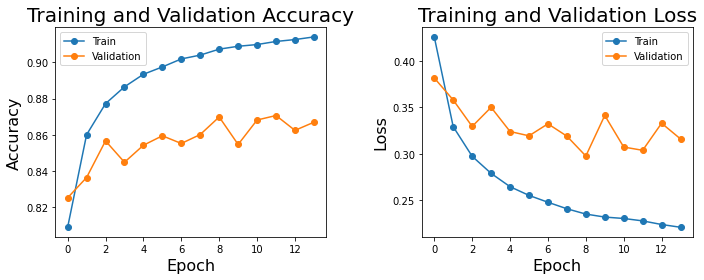

In [25]:
pcamlib.plot_history(hist_df)

In [ ]:
%%time
pcamlib.print_test_accuracy(cnn, test_pipeline)

In [26]:
%%time
y_proba = pcamlib.generate_y_proba(cnn, test_pipeline, class_1=False, save=True, filepath='data/y_proba/cnn1.1_y_proba.csv')

CPU times: user 20.9 s, sys: 2.51 s, total: 23.5 s
Wall time: 23.4 s


In [ ]:
# Uncomment to load y_proba from file if not running the model
# y_proba = pcamlib.load_y_proba('data/y_proba/cnn1_y_proba.csv')
# y_proba

In [27]:
%%time
y_pred = pcamlib.generate_y_pred(y_proba)

CPU times: user 13.1 ms, sys: 0 ns, total: 13.1 ms
Wall time: 13 ms


In [28]:
%%time
y_true = pcamlib.generate_y_true(pcam)

CPU times: user 23.5 s, sys: 1.93 s, total: 25.5 s
Wall time: 20.5 s


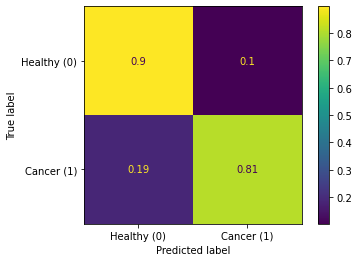

In [29]:
pcamlib.plot_cf_matrix(y_true, y_pred, normalize=True)

In [30]:
pcamlib.print_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.8264    0.8977    0.8606     16391
           1     0.8880    0.8112    0.8479     16377

    accuracy                         0.8545     32768
   macro avg     0.8572    0.8545    0.8542     32768
weighted avg     0.8572    0.8545    0.8542     32768



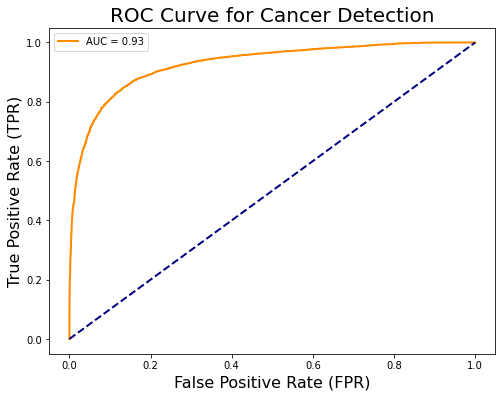

Area under curve (AUC):0.9276060367103509
(8431,)
(8431,)


In [31]:
pcamlib.plot_roc_curve(y_true, y_proba)

12
15
20
26
28
33
44
50
53


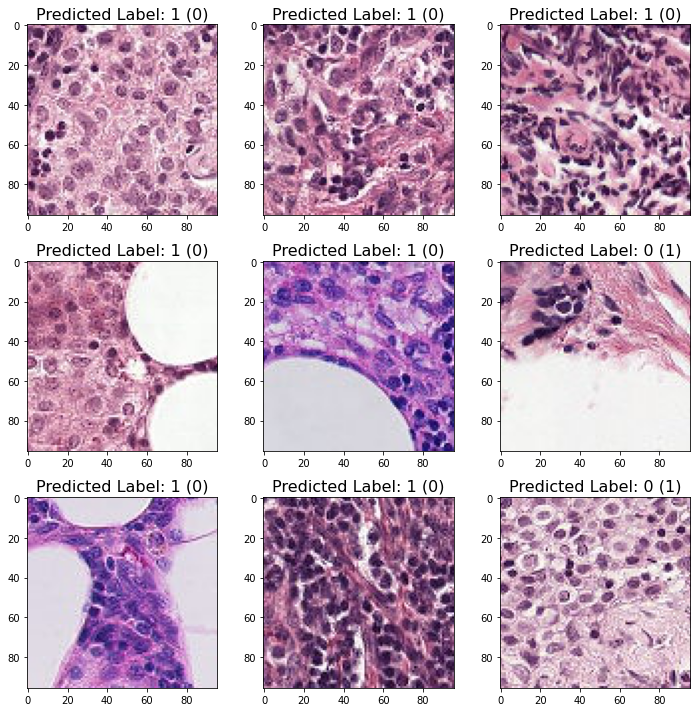

In [32]:
pcamlib.plot_misclassified_images(pcam, y_true, y_pred)